# Set-up

In [117]:
#pip install num2words
!pip install unidecode

In [118]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import unidecode
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [119]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes et fonctions

In [120]:
TOP = 50
REGEX = '[a-z0-9]+[#-]?\+{0,2}[a-z0-9]*'

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
EXTRA_SW = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb', 'without', 'behind', \
            'within')

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = []
    
    for w in tknzr.tokenize(unidecode.unidecode(col).lower()):
        if w not in sw and not w.isdigit():
            pos = get_wordnet_pos(w)
            if pos != 'n':
                continue
            else:
                temp.append(stmr.stem(lmtzr.lemmatize(w, pos)))
            
    return ' '.join(temp)

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

# Chargement

In [121]:
freq = defaultdict()

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding="ISO-8859-1", \
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)
train = train.apply(lambda x: x.astype(str).str.lower())

print(train.info())

cols = list(train.columns)
freq = recap_cols(train, cols)

train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 59549234 to 61503209
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB
None
Dénombrenent des mots
	Title  :  491335 dont  39914 distincts
	Body   : 9071299 dont 1163946 distincts
	Tags   :   50000 dont  32111 distincts


,Title,Body,Tags
59549234,how to determine the smallest common divisor o...,<p>i was asked the following question during a...,<string><algorithm>
59549281,how to use a trait object that contains a meth...,<p>what's the correct way to use a trait objec...,<rust>
59549471,why a named function declaration isn't hoisted...,<p>is putting the function declaration beside ...,<javascript>
59549568,getting value of input causing flickering in r...,<p>i am attempting to track the value of two l...,<javascript><css><reactjs><react-hooks><react-...
59549600,how to assign a vector of atomic types?,<p>how can i assign the members of a vector wi...,<c++><multithreading><c++11><stdvector><stdato...


# Nettoyage du dataframe

In [122]:
# Stopwords nltk 
std_sw = set(nltk.corpus.stopwords.words('english')) 

tokenizer = nltk.RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

print('='*50)

for col in ['Title', 'Body']:
    if col == 'Body':
        print('Conversion html de "{}" '.format(col), end='')
        start_time = timeit.default_timer()

        # Convertion du html en chaine standard 
        train[col] = train[col].apply(conv_html)

        elapsed = timeit.default_timer() - start_time
        print('-> OK en {:.3} sec'.format(elapsed))

    print('Nettoyage/lemmatisation de "{}" '.format(col), end='')
    start_time = timeit.default_timer()

    # Tokenisation et suppression des stopwords
    train[col] = train[col].apply(clean_field, tknzr=tokenizer, \
                                  sw=std_sw, lmtzr=lemmatizer, stmr=stemmer)

    # Suppression des radicaux qui ne me semblent pas discriminants (ex. use, ...)
    # et des chiffres (1, 0, 2003, ...)
    train[col] = train[col].apply(lambda x: ' '.join([w for w in x.split() \
                                                      if w not in EXTRA_SW]))

    elapsed = timeit.default_timer() - start_time
    print('-> OK en {:.3} sec'.format(elapsed))

train['full']  = train.Title + ' ' + train.Body
cols.append('full')

print('Traitement des tags ', end='')
start_time = timeit.default_timer()

# Epurage et tri des tags
train['Tags'] = train['Tags'].apply(lambda x: ' '.join(sorted(x[1:-1].split('><'))))

# Ajout du nombre de Tags 
train['nTags'] = train['Tags'].apply(lambda x: len(x.split()))

# Etiquetage des tags
#train['Tags_lbl'] = lbl.fit_transform(train.Tags)

elapsed = timeit.default_timer() - start_time
print('-> OK en {:.3} sec'.format(elapsed))

freq = recap_cols(train, cols)

print('{} groupes de tags distincts'.format(len(train.Tags.value_counts())))
print('='*50)

train.head()

Nettoyage/lemmatisation de "Title" -> OK en 67.2 sec
Conversion html de "Body" -> OK en 36.5 sec
Nettoyage/lemmatisation de "Body" -> OK en 4.67e+02 sec
Traitement des tags -> OK en 0.118 sec
Dénombrenent des mots
	Title  :  249933 dont  15867 distincts
	Body   : 1621599 dont  58732 distincts
	Tags   :  155810 dont  11234 distincts
	full   : 1871532 dont  61369 distincts
32084 groupes de tags distincts


,Title,Body,Tags,full,nTags
59549234,determin divisor string,question job interview part problem mind probl...,algorithm string,determin divisor string question job interview...,2
59549281,trait object contain method return refer self,correct trait object contain method return ref...,rust,trait object contain method return refer self ...,1
59549471,function declar put insid return statement,function declar besid return statement functio...,javascript,function declar put insid return statement fun...,1
59549568,valu input react,track valu two login input field valu chang va...,css javascript react-hooks react-state-managem...,valu input react track valu two login input fi...,5
59549600,assign vector type,assign member vector type,c++ c++11 multithreading stdatomic stdvector,assign vector type assign member vector type,5


## Nombre de mots dans les Title

In [123]:
temp = pd.DataFrame()
temp['len'] = train.Title.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.000000
mean,4.998660
std,1.931821
min,0.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,20.000000


## Nombre de mots dans les Body

In [124]:
temp = pd.DataFrame()
temp['len'] = train.Body.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.000000
mean,32.431980
std,25.406105
min,0.000000
25%,17.000000
50%,26.000000
75%,40.000000
max,811.000000


In [125]:
backup = train.copy()

# Explorations

## Jeu de données

Text(0.5, 1.0, 'Top 50 dans Tags')

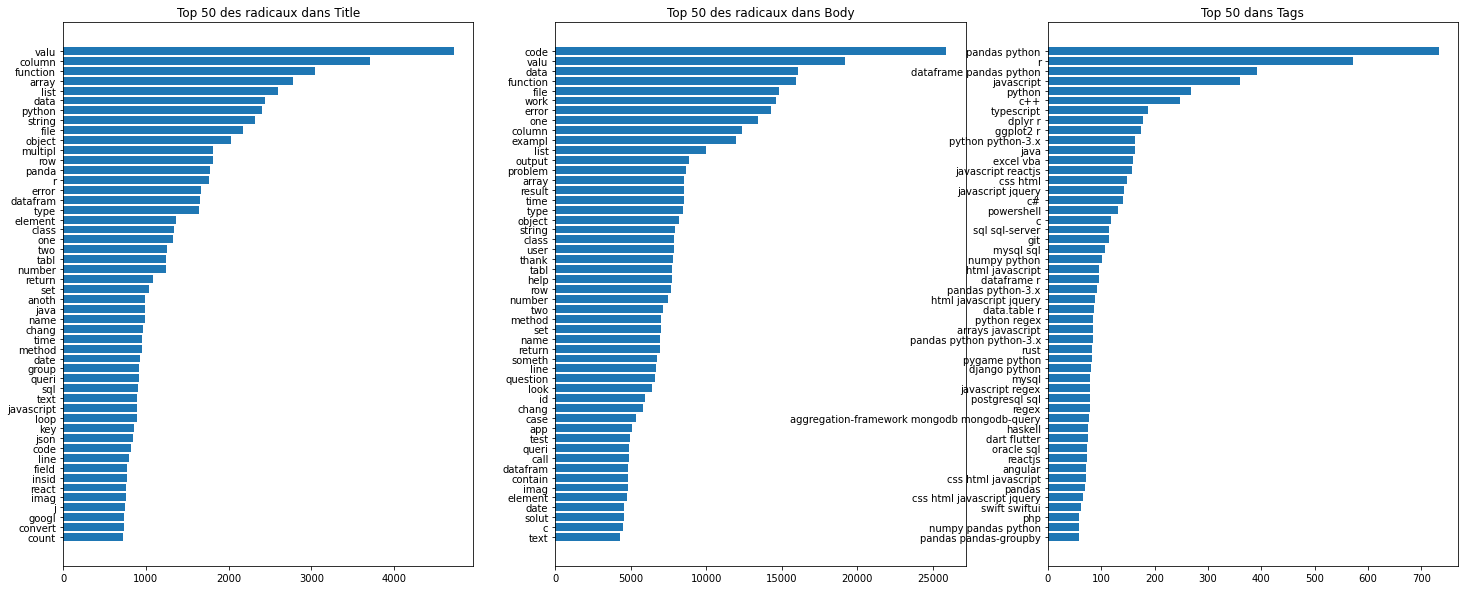

In [127]:
cpt = 0 
fig = plt.figure(figsize=(25, 10))

for col in ['Title', 'Body']:
    cpt += 1
    plt.subplot(1, 3, cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des radicaux dans {}'.format(TOP, col))

temp = train.Tags.value_counts().to_frame('counts')
plt.subplot(133)
plt.barh(temp.sort_values(by='counts', ascending=True)[-TOP:].index, 
         temp.sort_values(by='counts', ascending=True)[-TOP:].counts)
plt.title('Top {} dans Tags'.format(TOP))

## Top Tags unitaires

Text(0.5, 1.0, 'Distribution du nombre de tags par question')

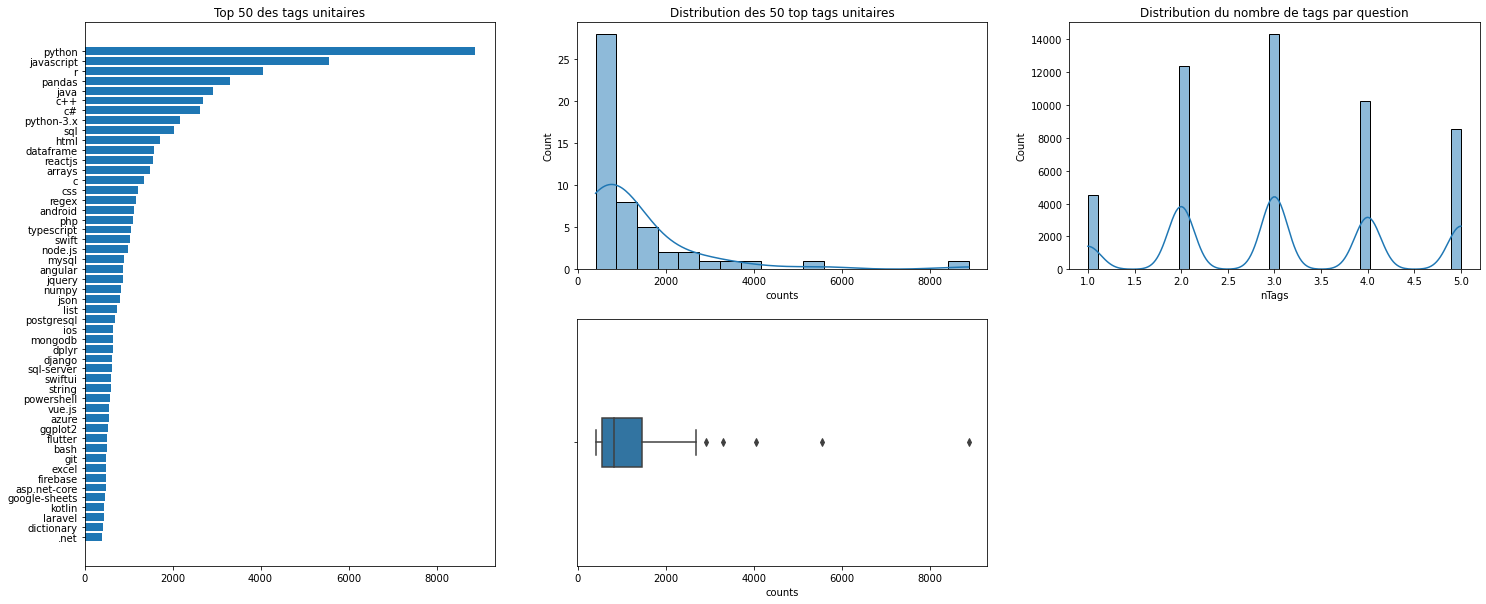

In [128]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.barh([k for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])])
plt.title('Top {} des tags unitaires'.format(TOP))

temp = pd.DataFrame.from_dict(dict(freq['Tags'][:TOP]), orient='index')\
                              .rename(columns={0:'counts'})
plt.subplot(232)
plt.title('Distribution des {} top tags unitaires'.format(TOP))
sns.histplot(temp.counts, kde=True)

plt.subplot(235)
sns.boxplot(x=temp.counts, width=0.2)

plt.subplot(233)
sns.histplot(train['nTags'], kde=True)
plt.title('Distribution du nombre de tags par question')

In [129]:
pd.DataFrame(freq['Tags']).rename(columns={0:'Tag', 1:'count'}).describe()

,count
count,11234.000000
mean,13.869503
std,135.398602
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,8882.000000


# Réductions


## 50 top tags des nregistrements avec 1 seul tag

In [131]:
train_1T = train[train.nTags == 1]
freq = recap_cols(train_1T, cols)
print(train.shape)
train_1T.head()

Dénombrenent des mots
	Title  :   20829 dont   2937 distincts
	Body   :  118464 dont   8916 distincts
	Tags   :    4540 dont    191 distincts
	full   :  139293 dont   9324 distincts
(50000, 5)


,Title,Body,Tags,full,nTags
59549281,trait object contain method return refer self,correct trait object contain method return ref...,rust,trait object contain method return refer self ...,1
59549471,function declar put insid return statement,function declar besid return statement functio...,javascript,function declar put insid return statement fun...,1
59549607,key object docker inspect format name network ...,command extract output question extract reacth...,docker,key object docker inspect format name network ...,1
59549746,troubl base r work,base function work r base tappli function reas...,r,troubl base r work base function work r base t...,1
59549939,altern inner join cartesian product,queri inner join think inner join edit edit dd...,mysql,altern inner join cartesian product queri inne...,1


Dénombrenent des mots
	Title  :   18208 dont   2568 distincts
	Body   :  102953 dont   7948 distincts
	Tags   :    3978 dont     50 distincts
	full   :  121161 dont   8312 distincts


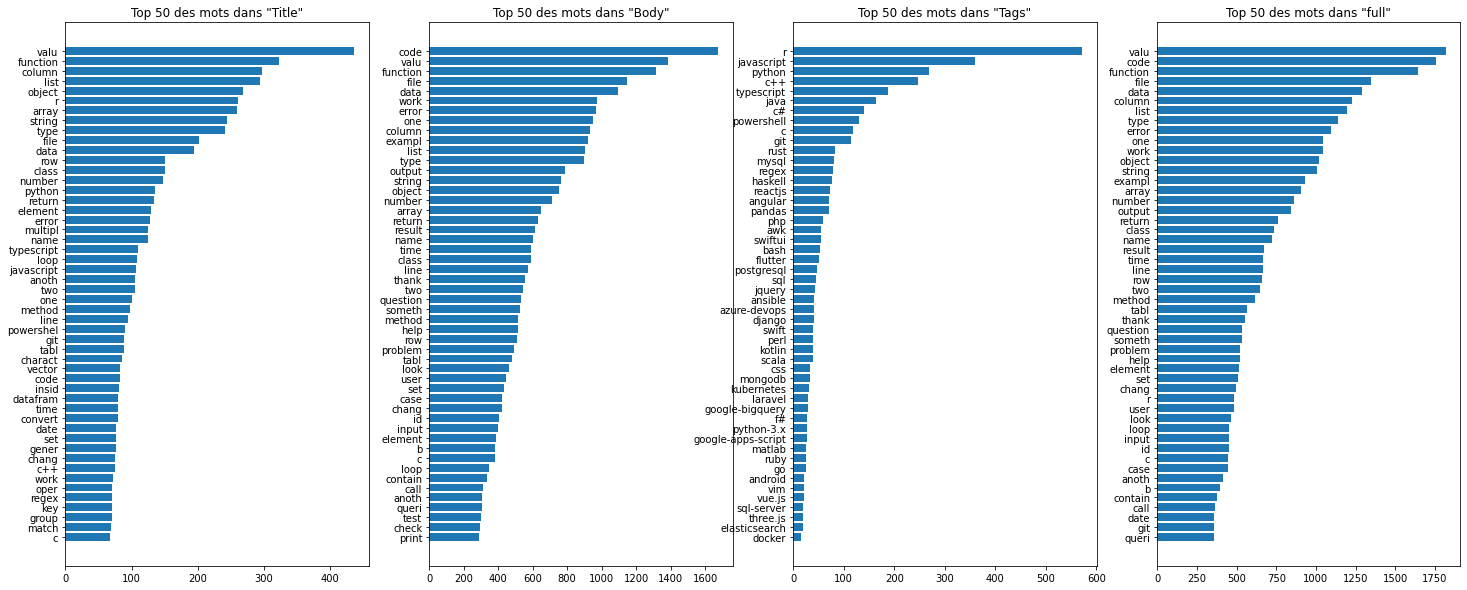

In [132]:
cpt = 1
train_1T = train_1T[train_1T.Tags.isin(dict(freq['Tags'][:TOP]).keys())]

freq = recap_cols(train_1T, cols)

fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

## Bag of words des 2 mots les plus féquents pour chaque tag unitaire

In [133]:
# Dictionnaire des index des enregistrements contenant chaque tag
dict_Tags = defaultdict(dict) 

for i, c in train.iterrows():
    for t in c['Tags'].split():
        try:
            dict_Tags['idx'][t].append(i)
        except KeyError:
            dict_Tags['idx'][t] = [i]

In [134]:
# Ajout des 2 mots les plus utilisés dans TItre et Body pour chaque tag 
tag_kw = set()

for k in dict_Tags['idx'].keys():
    temp = []
    val = train[train.index.isin(dict_Tags['idx'][k])]['full']
    new = Counter(' '.join(val).split()).most_common(2)
    dict_Tags['kw'][k] = new
    for i, j in new:
        tag_kw.add(i)

print('Soit {} radicaux distincts restants'.format(len(tag_kw)))

Soit 4031 radicaux distincts restants


Dénombrenent des mots
	Title  :  222368 dont   3849 distincts
	Body   : 1343341 dont   4012 distincts
	Tags   :  155810 dont  11234 distincts
	full   : 1871532 dont  61369 distincts


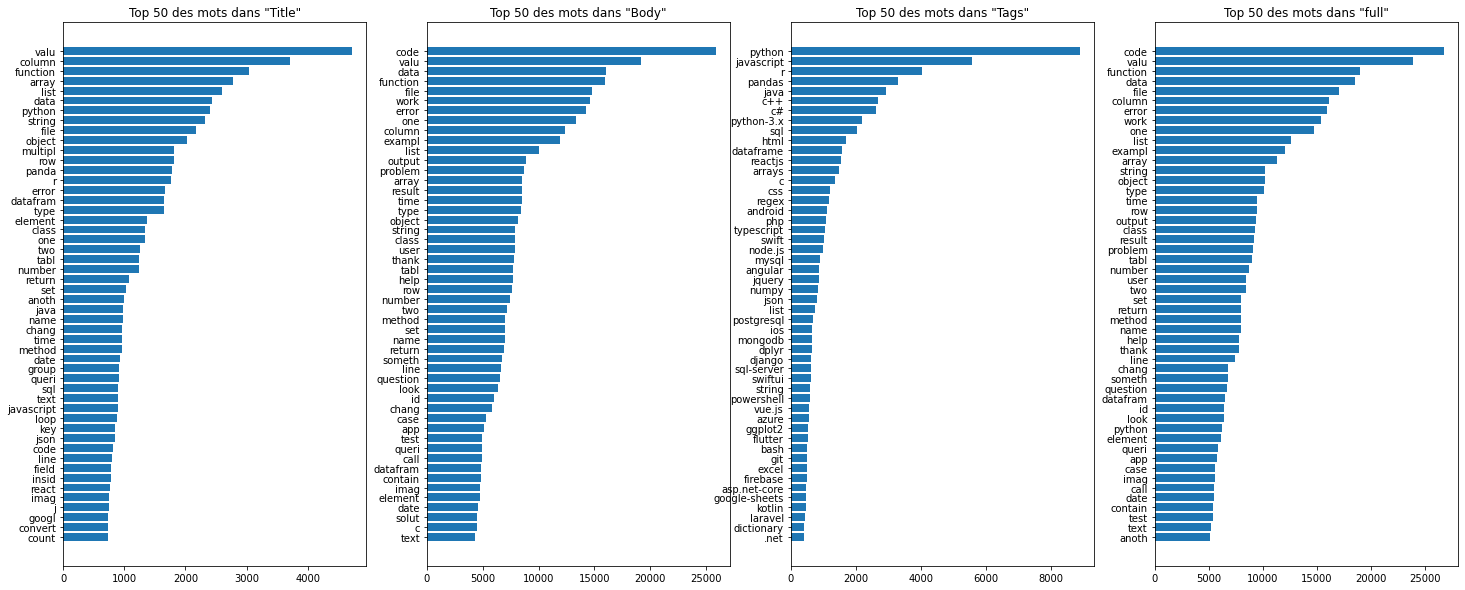

In [135]:
train2 = train.copy()
train2.Title = train2.Title.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))
train2.Body = train2.Body.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))

freq2 = recap_cols(train2, cols)

fig = plt.figure(1, figsize=(25, 10))
cpt=1
for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

## Bag of words des 2 mots les plus féquents pour chaque tag

In [136]:
# Dictionnaire des index des enregistrements contenant chaque tag
dict_Tags = defaultdict(dict) 

for i, c in train.iterrows():
    try:
        dict_Tags['idx'][c['Tags']].append(i)
    except KeyError:
        dict_Tags['idx'][c['Tags']] = [i]

print('{} tags'.format(len(dict_Tags['idx'])))

32084 tags


In [137]:
# Ajout des 2 mots les plus utilisés dans TItre et Body pour chaque tag 
tag_kw = set()

for k in dict_Tags['idx'].keys():
    temp = []
    val = train[train.index.isin(dict_Tags['idx'][k])]['full']
    new = Counter(' '.join(val).split()).most_common(2)
    dict_Tags['kw'][k] = new
    for i, j in new:
        tag_kw.add(i)

print('Soit {} radicaux distincts restants'.format(len(tag_kw)))

Soit 6847 radicaux distincts restants


Dénombrenent des mots
	Title  :  234986 dont   6104 distincts
	Body   : 1459082 dont   6794 distincts
	Tags   :  155810 dont  11234 distincts


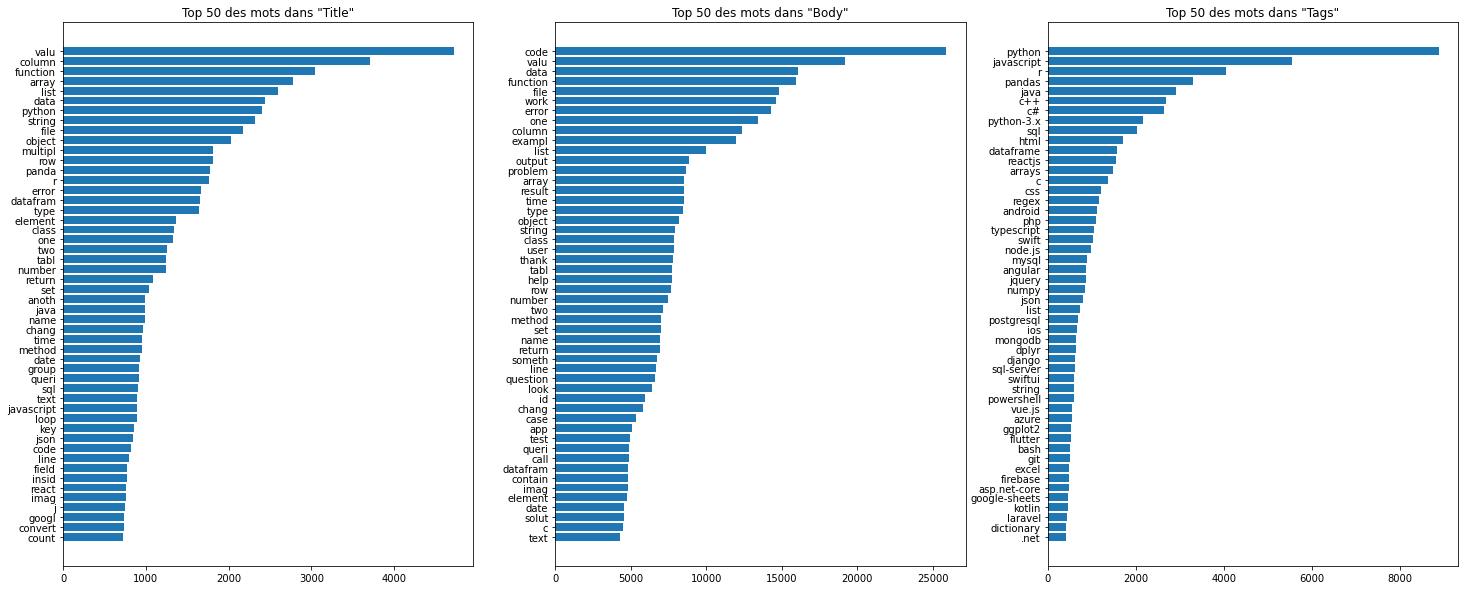

In [138]:
train2 = train.copy()
train2.Title = train2.Title.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))
train2.Body = train2.Body.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))

cols = ['Title', 'Body', 'Tags']
freq2 = recap_cols(train2, cols)

fig = plt.figure(1, figsize=(25, 10))
cpt=1
for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

## Top tags
Je conserve les 100 tags les plus fréquents

In [139]:
top_tags = [i for i, j in Counter(' '.join(train.Tags).split()).most_common(100)]
top_tags[:10]

['python',
 'javascript',
 'r',
 'pandas',
 'java',
 'c++',
 'c#',
 'python-3.x',
 'sql',
 'html']

### Création de la nouvelle feature

In [140]:
train['top_tags'] = train.Tags.apply(lambda x: ' '.join([w for w in x.split() \
                                                         if w in top_tags]))
train.head()

,Title,Body,Tags,full,nTags,top_tags
59549234,determin divisor string,question job interview part problem mind probl...,algorithm string,determin divisor string question job interview...,2,algorithm string
59549281,trait object contain method return refer self,correct trait object contain method return ref...,rust,trait object contain method return refer self ...,1,rust
59549471,function declar put insid return statement,function declar besid return statement functio...,javascript,function declar put insid return statement fun...,1,javascript
59549568,valu input react,track valu two login input field valu chang va...,css javascript react-hooks react-state-managem...,valu input react track valu two login input fi...,5,css javascript react-hooks reactjs
59549600,assign vector type,assign member vector type,c++ c++11 multithreading stdatomic stdvector,assign vector type assign member vector type,5,c++ c++11 multithreading


### Suppresion des top_tags non renseignés

In [141]:
len(train[train.top_tags == ''])

3603

In [142]:
train.drop(train[train.top_tags == ''].index, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46397 entries, 59549234 to 61503205
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     46397 non-null  object
 1   Body      46397 non-null  object
 2   Tags      46397 non-null  object
 3   full      46397 non-null  object
 4   nTags     46397 non-null  int64 
 5   top_tags  46397 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.5+ MB


In [143]:
train['nTags'] = train.top_tags.apply(lambda x: len(x.split()))
train.nTags.value_counts().to_frame().sort_index()

,nTags
1,21227
2,17315
3,6350
4,1371
5,134


# Export

In [145]:
with open('OC_DS_P6_backup.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(train[['Title', 'Body', 'full', 'top_tags']])
    pickler.dump(EXTRA_SW)
    pickler.dump(REGEX)